# Introduction

I am following along with Chapter 2 of @fastbook2020.

## Preliminaries

* Install the jmd_imagescraper [library](https://github.com/joedockrill/jmd_imagescraper/tree/master/) using `!pip3 install jmd_imagescraper`

* I set FASTAI_HOME in my .bashrc so that datasets downloaded using Fastai are stored under a different location than the default. I do this because the default location, /home/kaushik/.fastai, is space constrained. Feel free to omit this step. 
```
export FASTAI_HOME=/data/kaushik/.fastai
export PATH=$FASTAI_HOME:$PATH
```

# Download and Clean Images

In [ ]:
from jmd_imagescraper.core import *
from fastai.vision.all import *

See utility function to download images, using the Duck Duck Go search engine, below (modified from [here](#https://drscotthawley.github.io/blog/scottergories/2021/06/17/Contrasting-Contrastive-Loss.html)).

In [ ]:
#| code-fold: true
def scrape_images(path, labels, search_suffix, erase_dir=True, max_images=20):
    if erase_dir:
        !rm -rf {path}
    
    if not path.exists():
        path.mkdir(parents=True)
    
    for some_label in labels:
        duckduckgo_search(path, some_label,\
                          f'{some_label} {search_suffix}', max_results=max_images)
        
    filenames = get_image_files(path)
    failed = verify_images(filenames)
    
    failed.map(Path.unlink);
    if failed != []:
        _ = [filenames.remove(f) for f in failed]
    
    # To avoid Transparency warnings, convert PNG images to RGBA
    # https://forums.fast.ai/t/errors-when-training-the-bear-image-classification-model/83422/9
    converted = L()
    for image in filenames:
        if '.png' in str(image):
            im = Image.open(image)
            converted.append(image)  # old file name before resaving
            im.convert("RGBA").save(f"{image}2.png")    
            
    converted.map(Path.unlink); # delete originals
    
    total_images = len(get_image_files(path))
    print(f"After checking for issues, {total_images} (total) images remain.")
    
    return path

Get 100 images for each kind of bear.

In [ ]:
labels = 'grizzly','black','teddy'
path = scrape_images(Path('/data/kaushik/bears'), labels, 'bear', max_images=100)

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


After checking for issues, 300 (total) images remain.


# Define the DataBlock
A _DataBlock_ is a _template_ for creating a _DataLoader_

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=0),
    get_y=parent_label,
    item_tfms=Resize(128))

## Inspect a few items from the validation set

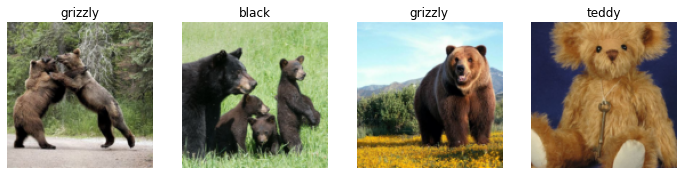

In [ ]:
#collapse-output
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

## Inspect effect of Data Augmentations

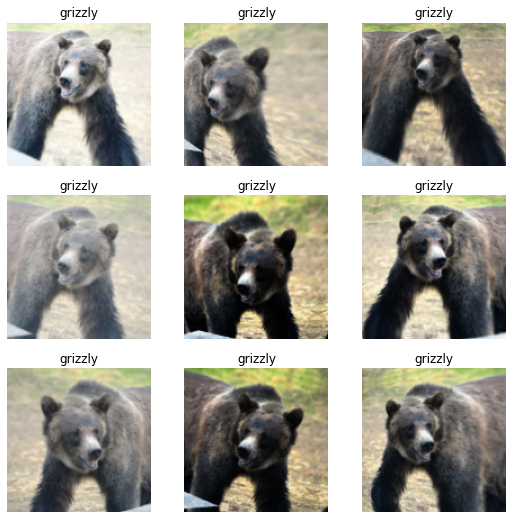

In [ ]:
#collapse-output
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=9, nrows=3, unique=True)

# Train Model

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(228, min_scale=0.5), 
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.668255,0.410353,0.150000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.551829,0.221585,0.100000,00:02
1,0.401239,0.252073,0.083333,00:02
2,0.327227,0.271660,0.083333,00:02
3,0.274876,0.251819,0.083333,00:02


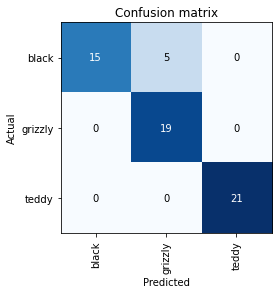

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

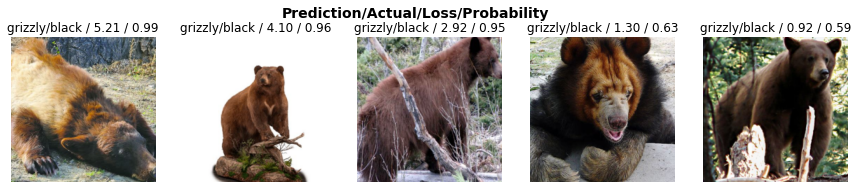

In [ ]:
interp.plot_top_losses(5, nrows=1)

## Clean the data

In [ ]:
from fastai.vision.widgets import *

The following will give us a UI that allows to mark images that are mislabeled (for relabeling) or completely wrong (for deletion).

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

So for each label we do the following: 

* First we choose the images to delete or relabel. 

* Second we run the following:
```
for idx in cleaner.delete() : cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

Items that need to be deleted or whose label needs to be changed

In [ ]:
cleaner.delete(), cleaner.change()

((#4) [5,9,21,27],
 (#11) [(0, 'black'),(1, 'black'),(2, 'black'),(3, 'black'),(11, 'black'),(14, 'black'),(15, 'black'),(16, 'black'),(17, 'black'),(19, 'black')...])

In [ ]:
for idx in cleaner.delete() : cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Retrain Model

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(228, min_scale=0.5), 
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.947632,0.435558,0.189655,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.471205,0.192515,0.103448,00:02
1,0.352979,0.143951,0.086207,00:02
2,0.290317,0.153008,0.068965,00:02
3,0.261623,0.159573,0.051724,00:02


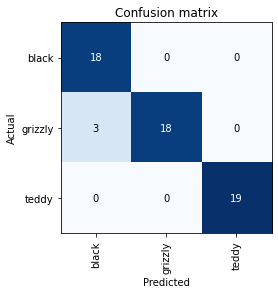

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Performance on Black bears has improved but we are now misclassifying some Grizzlies as Black bears.

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

       black       0.86      1.00      0.92        18
     grizzly       1.00      0.86      0.92        21
       teddy       1.00      1.00      1.00        19

    accuracy                           0.95        58
   macro avg       0.95      0.95      0.95        58
weighted avg       0.96      0.95      0.95        58



# Save the model

In [ ]:
learn.export('/data/kaushik/20210731/bear_v0/classifier.pkl')

# Load serialized model

In [ ]:
learn_inf = load_learner('/data/kaushik/20210731/bear_v0/classifier.pkl')

# Inference

In [ ]:
def get_prediction(model, image_location):
    return model.predict(image_location)

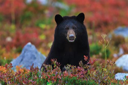

In [ ]:
test_black_bear_image_location = '../test_images/black_bear.jpg'
im = Image.open(test_black_bear_image_location)
im.to_thumb(128,128)

In [ ]:
pred, pred_idx, probs = get_prediction(learn_inf, test_black_bear_image_location)
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

'Prediction: black; Probability: 1.0000'

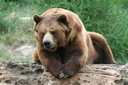

In [ ]:
test_grizzly_image_location = '../test_images/grizzly.jpg'
im = Image.open(test_grizzly_image_location)
im.to_thumb(128,128)

In [ ]:
pred, pred_idx, probs = get_prediction(learn_inf, test_grizzly_image_location)
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

'Prediction: grizzly; Probability: 1.0000'

## Sadness
So far so good, test images of bears seem to be recognized perfectly. So now there is nowhere to go but downhill.

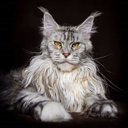

In [ ]:
test_mainecoon_image_location = '../test_images/mc.jpg'
im = Image.open(test_mainecoon_image_location)
im.to_thumb(128,128)

In [ ]:
pred, pred_idx, probs = get_prediction(learn_inf, test_mainecoon_image_location)
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

'Prediction: teddy; Probability: 0.8470'

So our classifier is very confident that the Maine Coon is a Teddy! 

We work through how to tackle this issue by the use of multi-label classification in [this](https://nasheqlbrm.github.io/blog/fastai/jupyter/2021/08/12/Multi-Label-Classification.html) post.

# Model Demo

Chapter 2 of the book shows how to create a notebook app with Voila. However I recently ran into [gradio](https://www.gradio.app) which provides a neat way to quickly demo your model. The demo below will only run __as long as my notebook is up__. 

:::{.callout-tip}

Gradio has a paid [hosted](https://www.gradio.app/introducing-hosted) option which gives on the ability to have a permanent link.

:::

In [ ]:
import gradio as gr

def gradio_predict(img):
    pred, pred_idx, probs =  learn_inf.predict(img)    
    return {learn_inf.dls.vocab[i]: float(probs[i]) for i in range(len(probs))}

label = gr.outputs.Label(num_top_classes=3)

In [ ]:
#| include: false
gradio_predict(PILImage.create('../test_images/mc.jpg'))

{'black': 0.12473726272583008,
 'grizzly': 0.02830268070101738,
 'teddy': 0.8469600081443787}

In [ ]:
#| output: false
iface = gr.Interface(fn=gradio_predict,
                     inputs=gr.inputs.Image(shape=(224,224)),
                     outputs=label)
iface.launch(share=True)

Running locally at: http://127.0.0.1:7860/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://37325.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://37325.gradio.app')

The following __screenshot__ shows the finished product. The UI allows one to upload an image, click submit and that's it. Pretty neat!

![](../images/gradio_screenshot2.png)